In [2]:
################################################################
### Implement Variational Autoencoder (VAE) for MNIST data set
################################################################

# Import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-ticks')

# Define a function to look at MNIST images
def imshow(images, labels=None, num_images_display=5):
    # Arrange images on a grid
    img = torchvision.utils.make_grid(images[:num_images_display])
    
    # Make the images a numpy array
    np_img = img.numpy()
    
    # Show the images
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='Greys')
    plt.show()
    
    # Display the labels if they are provided
    if labels is not None:
        print(" ".join([f"{label}" for label in labels[:num_images_display]]))

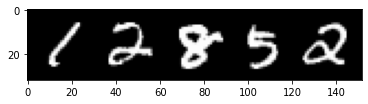

1 2 8 5 2


In [136]:
# Define random seed
torch.manual_seed(42)

# Define the batch size
batch_size = 64

# Define the transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.5], [0.5]),
    ])

# Train Data
train_set = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Test Data
test_set = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Show the images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Display some images
imshow(images, labels=labels)

In [246]:
# Define model
class Net(nn.Module):
    def __init__(self):
        # Initialize super class
        super().__init__()
        
        # Define hyper parameters
        self.dim_latent = 32
        
        # Define components
        # Encoder
        self.fc1         = nn.Linear(28*28, 400)
        self.fc2_mu      = nn.Linear(400, self.dim_latent)
        self.fc2_log_var = nn.Linear(400, self.dim_latent)
        
        # Decoder
        self.fc3 = nn.Linear(self.dim_latent, 400)
        self.fc4 = nn.Linear(400, 28*28)
        
    def flatten(self, x):
        """ Flatten inputs. """
        return torch.flatten(x, 1)
    
    def unflatten(self, x):
        """ Unflatted inputs. """
        return x.view(-1, 1, 28, 28)
        
    def encode(self, x):
        """ Encode x. """
        # Flatten the inputs
        x = self.flatten(x)
        x = F.relu( self.fc1(x) )
        #x = F.relu( self.fc2(x) )
        mu      = self.fc2_mu(x)
        log_var = self.fc2_log_var(x)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        """ Use reparameterization trick to avoid gradients of RVs. """
        # sigma = sqrt(var) = [exp( log(var) )]^0.5 = exp( 0.5*log(var) )
        sigma = torch.exp(0.5*log_var)
        
        # Sample normal random distribution
        eps   = torch.randn_like(sigma)
        
        # Sample z
        z = mu+eps*sigma
        #z = mu
        return z
    
    def decode(self, x):
        """ Decode x. """
        # Images should have values in [0, 1]
        x = F.relu( self.fc3(x) )
        x = torch.sigmoid( self.fc4(x) )
        # Unflatten the inputs
        x = self.unflatten(x)
        return x
        
    def forward(self, x):
        """ Define forward pass x->y. """
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var)
        x = self.decode(z)
        return x, mu, log_var
    
    def sample(self, num_samples=1):
        """ Sample by feeding random number to decoder. """
        # Sample from normal distribution
        z = torch.randn(num_samples, self.dim_latent)
        
        # Feed this into decoder and return it
        return self.decode(z)
        

# Initialize the network
net = Net()

# Define the criterion
def criterion_func(inputs, outputs, mu, log_var):
    """ Define a loss criterion. """
    # Reconstruction loss
    MSE = nn.MSELoss(reduction='sum')
    reconstruction_loss = MSE(inputs, outputs)
    #reconstruction = F.binary_cross_entropy(inputs, outputs, reduction='mean')
    
    # Latent Space - Gaussian loss
    latent_loss = -0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())
    #print(f"{reconstruction}/{gaussian_latent}")
    
    # Total loss
    total_loss = reconstruction_loss + latent_loss
    
    return total_loss, reconstruction_loss, latent_loss

# Define the criterion and optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

print('Definition complete')

Definition complete


[0-99] Loss: 0.0005044617969542742


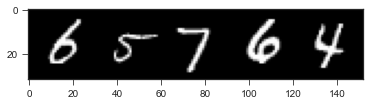

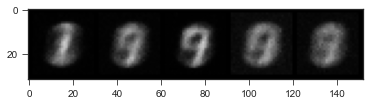

[0-199] Loss: 0.0005044617969542742


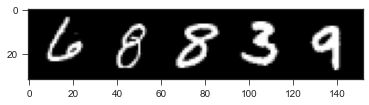

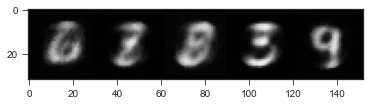

[0-299] Loss: 0.0005044617969542742


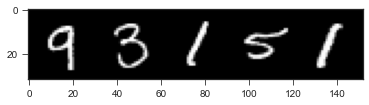

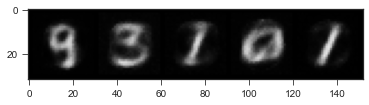

[0-399] Loss: 0.0005044617969542742


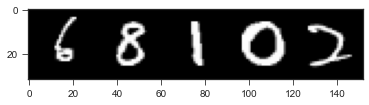

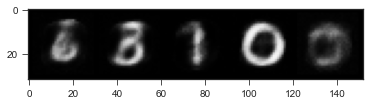

[0-499] Loss: 0.0005044617969542742


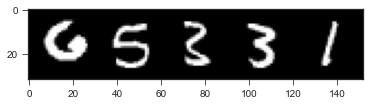

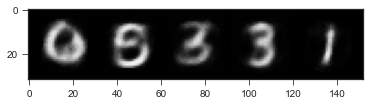

[0-599] Loss: 0.0005044617969542742


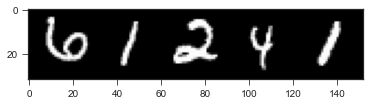

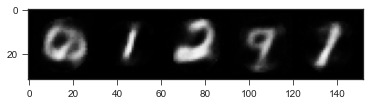

[0-699] Loss: 0.0005044617969542742


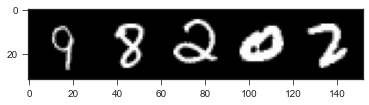

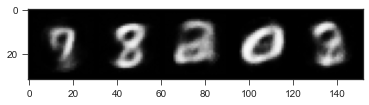

[0-799] Loss: 0.0005044617969542742


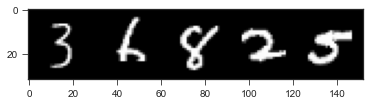

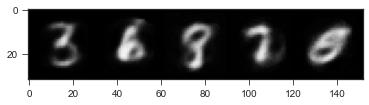

[0-899] Loss: 0.0005044617969542742


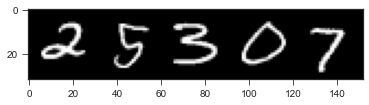

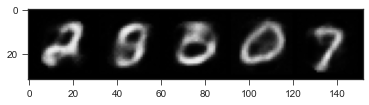

[1-99] Loss: 0.0005044617969542742


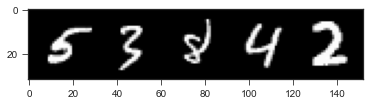

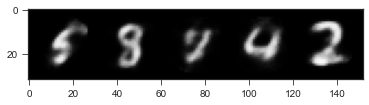

[1-199] Loss: 0.0005044617969542742


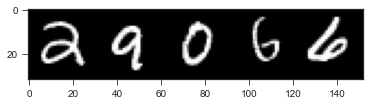

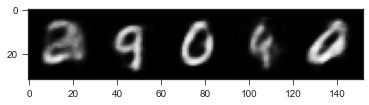

[1-299] Loss: 0.0005044617969542742


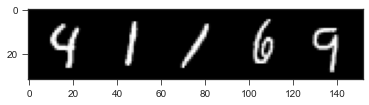

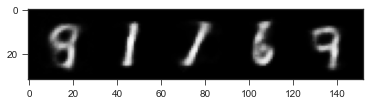

[1-399] Loss: 0.0005044617969542742


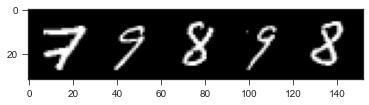

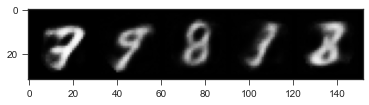

[1-499] Loss: 0.0005044617969542742


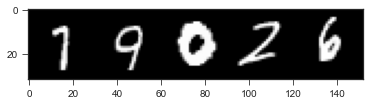

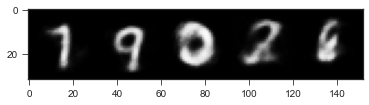

[1-599] Loss: 0.0005044617969542742


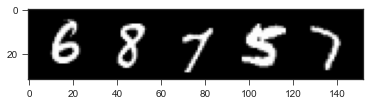

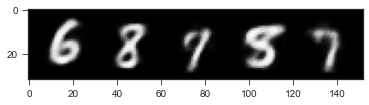

[1-699] Loss: 0.0005044617969542742


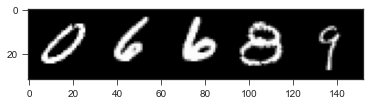

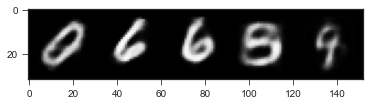

[1-799] Loss: 0.0005044617969542742


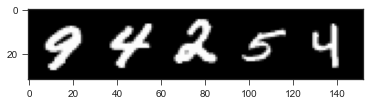

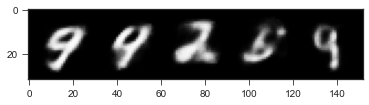

[1-899] Loss: 0.0005044617969542742


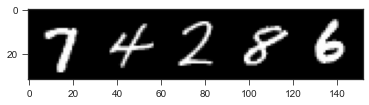

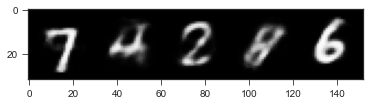

Training done (Duration: 0.75 min)


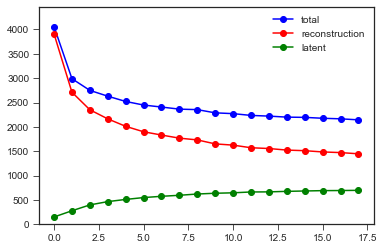

In [247]:
# TRAINING
num_epochs = 2
start_time = time.time()
running_total_losses = list()
running_reconstruction_losses = list()
running_latent_losses = list()
# Loop over epochs
for epoch in range(num_epochs):
    running_total_loss = 0.0
    running_reconstruction_loss = 0.0
    running_latent_loss = 0.0
    num_batches = 0
    # Loop over batches
    for batch_index, (inputs, labels) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, mu, log_var = net(inputs)
        
        # Calculate the loss
        #loss = criterion(outputs, labels)
        total_loss, reconstruction_loss, latent_loss = criterion_func(inputs, outputs, mu, log_var)
        
        # Calculate the backward pass (and thereby set the gradients of the parameters)
        total_loss.backward()
        
        # Update the parameters by performing an optimizer step
        optimizer.step()
        
        # Add the loss to the running loss
        num_batches += 1
        running_total_loss += total_loss.item()
        running_reconstruction_loss += reconstruction_loss.item()
        running_latent_loss += latent_loss.item()
        
        # Display results if needed
        #if batch_index%2000==1999:
        if batch_index%100==99:
            print(f"[{epoch}-{batch_index}] Loss: {running_total_loss/num_batches}")
            imshow(inputs)
            imshow(outputs)
            running_total_losses.append(running_total_loss/num_batches)
            running_reconstruction_losses.append(running_reconstruction_loss/num_batches)
            running_latent_losses.append(running_latent_loss/num_batches)
            
            # Set runners back to zero
            running_total_loss = 0.0
            running_reconstruction_loss = 0.0
            running_latent_loss = 0.0
            num_batches = 0
    
print(f"Training done (Duration: {(time.time()-start_time)/60:.2f} min)")
plt.figure
plt.plot(running_total_losses, 'bo-', label='total')
plt.plot(running_reconstruction_losses, 'ro-', label='reconstruction')
plt.plot(running_latent_losses, 'go-', label='latent')
plt.ylim([0, np.max(running_total_losses)*1.1])
plt.legend()
plt.show()

# Store model
PATH = './mnist_net_vae.pth'
torch.save(net.state_dict(), PATH)

In [1]:
########################################
# EVALUATION ON TEST SET
########################################
# Evaluate on test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs, labels = dataiter.next()

# Display some images
imshow(images, labels=labels)

# Load the network
net = Net()
net.load_state_dict(torch.load(PATH))

# Get Ouput
outputs, mu, log_var = net(inputs)

# Display auto-encoded images
imshow(images)

########################################
# TRANSLATE BETWEEN IMAGES
########################################
# Image translation
mu_1, log_var_1 = net.encode(images[0])
mu_2, log_var_2 = net.encode(images[2])
print(mu_1.shape)
print(mu_2.shape)

# Don't use a gradient for this translation
with torch.no_grad():
    # Define the interpolation steps
    num_steps = 10
    steps = np.linspace(0, 1, num_steps)
    
    # Generate images along the interpolation
    generated_images = list()
    for step in steps:
        # Generate z value of the interpolation
        z = (1-step)*mu_1 + step*mu_2
        
        # Generate the image using the decoder and append it
        generated_image = net.decode(z)
        generated_images.append( generated_image )

    # Stack the generated images and display them
    generated_images = torch.vstack(generated_images)
    print(generated_images.shape)
    imshow(generated_images, labels=None, num_images_display=num_steps)
    


# # Get the overall accuracy
# correct = 0.0
# total   = 0.0
# with torch.no_grad():
#     for (inputs, labels) in test_loader:
#         # Get predicted labels
#         predicted_labels = torch.argmax(net(inputs), 1)
        
#         # Get the number of correct labels in the batch
#         correct += (labels==predicted_labels).sum().item()
        
#         # Get the number of labels in the batch
#         total += labels.size(0)
        
# print(f"Accuracy: {100*correct/total:.2f}%")

NameError: name 'test_loader' is not defined

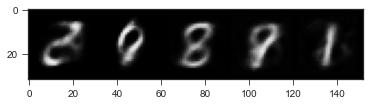

In [256]:
########################################
# RANDOMLY SAMPLE SOME IMAGES
########################################
samples = net.sample(num_samples=10)
imshow(samples)

In [240]:
# Get the latent Space Distributions
z_list = list()
with torch.no_grad():
    for (inputs, labels) in train_loader:
        mu, log_var = net.encode(inputs)
        z = net.reparametrize(mu, log_var)
        z_list.append(z)
        

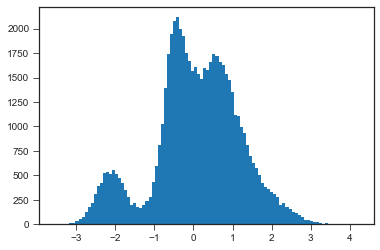

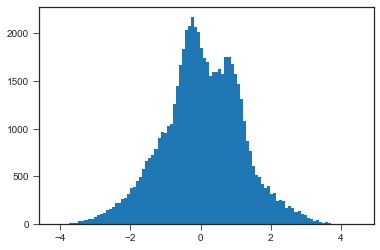

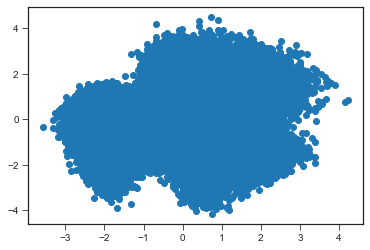

In [245]:
############################################################
# Display the distributions (training data) in latent space
############################################################
z_samples = torch.vstack(z_list).numpy()

# Loop over the latent coordinates and plot the histograms
for latent_coord in range(z_samples.shape[1]):
    z_samples_coord = z_samples[:, latent_coord]
    plt.hist(z_samples_coord, bins=100)
    plt.show()
    
# Display a pair plot of the samples
plt.figure()
plt.scatter(z_samples[:, 0], z_samples[:, 1])
plt.show()